In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
import scipy.ndimage
import cv2
import os
import json
import errno
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.layers import Dense, Flatten, Lambda, Activation, MaxPooling2D
from keras.layers.convolutional import Convolution2D
from keras.models import Sequential
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing import image
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.normalization import BatchNormalization
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
from scipy.stats import bernoulli

Using TensorFlow backend.


In [2]:
DATA_FILE = "./data/driving_log.csv"
DATA_DIR = "./data/"
CAMERA_ANGLE_CORRECTION = 0.229
GENERATOR_BATCH_SIZE = 32

In [3]:
dataset = pd.read_csv(DATA_FILE, usecols=[0, 1, 2, 3])

In [4]:
X, y = dataset.iloc[:,:-1], dataset.iloc[:, -1]
X, y = np.array(X), np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [5]:
n_train = X_train.shape[0]
n_test = X_test.shape[0]
n_classes = np.unique(y_train).shape[0]
print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of classes =", n_classes)

Number of training examples = 6428
Number of testing examples = 1608
Number of classes = 119


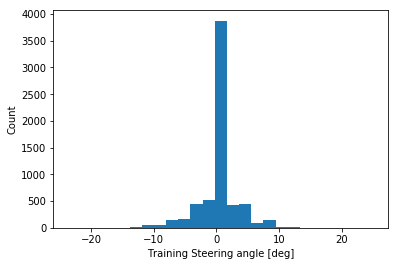

In [6]:
plt.hist(y_train*25, bins=25)
plt.xlabel('Training Steering angle [deg]')
plt.ylabel('Count')
plt.show()

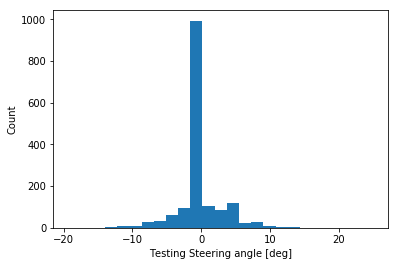

In [7]:
plt.hist(y_test*25, bins=25)
plt.xlabel('Testing Steering angle [deg]')
plt.ylabel('Count')
plt.show()

Image manipulation routines

In [8]:
# return images with alternative brightness
def img_alter_brightness(image):
    # convert to HSV so that its easy to adjust brightness
    img1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)

    # alternative brightness reduction factor
    alter_bright = .25+np.random.uniform()

    # Apply the brightness reduction to the V channel
    img1[:,:,2] = img1[:,:,2]*alter_bright

    # convert to RBG again
    img1 = cv2.cvtColor(img1,cv2.COLOR_HSV2RGB)
    return img1

In [9]:
#crops image from top and bottom - inputs are factors between 0 to 0.5
def img_crop(image, top, bottom):
    assert 0 <= top < 0.5 
    assert 0 <= bottom < 0.5

    img_top = int(np.ceil(image.shape[0] * top))
    img_bottom = image.shape[0] - int(np.ceil(image.shape[0] * bottom))

    return image[img_top:img_bottom, :]

In [10]:
#resize img. 
def img_resize(image, new_dim):
    return scipy.misc.imresize(image, new_dim)

In [11]:
# flip image
def img_flip(image, steering_angle, flip_prob=0.5):
    do_flip = bernoulli.rvs(flip_prob)
    if do_flip:
        return np.fliplr(image), -1 * steering_angle
    else:
        return image, steering_angle

In [12]:
# gamma reduction as brightness reduction technique
# http://www.pyimagesearch.com/2015/10/05/opencv-gamma-correction/
def img_brightness(image):
#    gamma = np.random.uniform(0.4, 1.5)
#    inv_gamma = 1.0 / gamma
#    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
#    return cv2.LUT(image, table)

    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    # Apply the brightness reduction to the V channel
    image1[:,:,2] = image1[:,:,2]*random_bright
    # convert to RBG again
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

In [13]:
# image shearing applied to it
# https://medium.com/@ksakmann/behavioral-cloning-make-a-car-drive-like-yourself-dc6021152713#.7k8vfppvk

def img_shear(image, steering_angle, shear_range=200):
    rows, cols, ch = image.shape
    dx = np.random.randint(-shear_range, shear_range + 1)
    random_point = [cols / 2 + dx, rows / 2]
    pts1 = np.float32([[0, rows], [cols, rows], [cols / 2, rows / 2]])
    pts2 = np.float32([[0, rows], [cols, rows], random_point])
    dsteering = dx / (rows / 2) * 360 / (2 * np.pi * 25.0) / 6.0
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, (cols, rows), borderMode=1)
    steering_angle += dsteering
    return image, steering_angle

In [14]:
# image rotation
def random_rotation(image, steering_angle, rotation_amount=15):
    angle = np.random.uniform(-rotation_amount, rotation_amount + 1)
    rad = (np.pi / 180.0) * angle
    return rotate(image, angle, reshape=False), steering_angle + (-1) * rad

In [15]:
# get altered image
def get_altered_image(image, steering_angle, top_crop=0.35, bottom_crop=0.1, resize_dim=(64, 64), shear_prob=0.9):
    do_shear = bernoulli.rvs(shear_prob)
    if do_shear == 1:
        image, steering_angle = img_shear(image, steering_angle)
    image = img_crop(image, top_crop, bottom_crop)
    image, steering_angle = img_flip(image, steering_angle)
    image = img_brightness(image)
    image = img_resize(image, resize_dim)
    return image, steering_angle

In [16]:
#generator expected by Keras
def img_generator(data, batch_size=GENERATOR_BATCH_SIZE):
    
    num_of_img = len(data)

    while True:
        
        X_batch = np.zeros((batch_size, 64, 64, 3), dtype=np.float32)
        y_batch = np.zeros((batch_size,), dtype=np.float32)
        i = 0
        random_indices = np.random.randint(0, num_of_img, batch_size)
        for index in random_indices:
            row = data.iloc[index]
            steering_angle = row['steering']

            # randomly choose the camera to take the image from
            camera = np.random.choice(['center', 'left', 'right'])
            if camera == 'left':
                steering_angle += CAMERA_ANGLE_CORRECTION
            elif camera == 'right':
                steering_angle -= CAMERA_ANGLE_CORRECTION

            image = load_img(DATA_DIR + row[camera].strip())
            image = img_to_array(image)
            image = np.array(image)
            
            X_batch[i], y_batch[i] = get_altered_image(image, steering_angle)
            i+=1
        
        yield X_batch, y_batch

In [17]:
# the model..
# Our model is based on NVIDIA's "End to End Learning for Self-Driving Cars" paper
# Source:  https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf

def get_model():
    model = Sequential()
    
    # normalization
    model.add(Lambda(lambda x: x / 127.5 - 1.0, input_shape=(64, 64, 3)))

    model.add(Convolution2D(24, 5, 5, border_mode='same', subsample=(2, 2)))
    model.add(Activation(activation_relu))
#    model.add(Dropout(DROPOUT))
#    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

    model.add(Convolution2D(36, 5, 5, border_mode='same', subsample=(2, 2)))
    model.add(Activation(activation_relu))
#    model.add(Dropout(DROPOUT))
#    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

    model.add(Convolution2D(48, 5, 5, border_mode='same', subsample=(2, 2)))
    model.add(Activation(activation_relu))
#    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

    model.add(Convolution2D(64, 3, 3, border_mode='same', subsample=(1, 1)))
    model.add(Activation(activation_relu))
#    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

    model.add(Convolution2D(64, 3, 3, border_mode='same', subsample=(1, 1)))
    model.add(Activation(activation_relu))
#    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

    model.add(Flatten())

    # Next, five fully connected layers
    model.add(Dense(1164))
#    model.add(Dropout(DROPOUT))
    model.add(Activation(activation_relu))

    model.add(Dense(100))
    model.add(Activation(activation_relu))

    model.add(Dense(50))
    model.add(Activation(activation_relu))

    model.add(Dense(10))
    model.add(Activation(activation_relu))

    model.add(Dense(1))

    model.summary()

    model.compile(optimizer=Adam(learning_rate), loss="mse", )
    return model

In [18]:
train_log = dataset.sample(frac=.8).reset_index(drop=True) # Shuffle
valid_log = dataset.sample(frac=.15).reset_index(drop=True) # Shuffle
test_log = dataset.sample(frac=.05).reset_index(drop=True) # Shuffle
train_gen = img_generator(train_log, batch_size=GENERATOR_BATCH_SIZE)
valid_gen = img_generator(train_log, batch_size=GENERATOR_BATCH_SIZE)
test_gen = img_generator(train_log, batch_size=GENERATOR_BATCH_SIZE)

In [19]:
print("Number of training examples =", len(train_log))
print("Number of validation examples =", len(valid_log))
print("Number of testing examples =", len(test_log))

Number of training examples = 6429
Number of validation examples = 1205
Number of testing examples = 402


In [20]:
def silent_delete(file):
    try:
        os.remove(file)
    except OSError as error:
        if error.errno != errno.ENOENT:
            raise

In [21]:
def save_model(model, model_name='model.json', weights_name='model.h5'):
    silent_delete(model_name)
    silent_delete(weights_name)

    json_string = model.to_json()
    with open(model_name, 'w') as outfile:
        json.dump(json_string, outfile)

    model.save_weights(weights_name)

In [22]:
def show_image_processing(image1, steering_angle1):
    
    

    plt.figure()
    title = 'Original Image, Steering Angle {}'.format(steering_angle1)
    plt.text(350, 30, title, rotation=0, fontsize=16)
    plt.imshow(image1)
    
    plt.figure()
    image, steering_angle = img_shear(image1, steering_angle1)
    title = 'Random Shear applied to Image, Steering Angle {0:.2f}'.format(steering_angle)
    plt.text(350, 30, title, rotation=0, fontsize=16)
    plt.imshow(image)

    plt.figure()
    top_crop=0.35
    bottom_crop=0.1
    image = img_crop(image1,top_crop,bottom_crop)
    title = 'Cropped Image, Top {}%, Bottom {}%'.format(top_crop*100, bottom_crop*100)
    plt.text(350, 30, title, rotation=0, fontsize=16)
    plt.imshow(image)

    plt.figure()
    image, steering_angle = img_flip(image1, steering_angle1, flip_prob=1.0)
    title = 'Flipped Image, Steering Angle {0:.2f}'.format(steering_angle)
    plt.text(350, 30, title, rotation=0, fontsize=16)
    plt.imshow(image)

    plt.figure()
    image = img_brightness(image1)
    title = 'Brightness Reduction'
    plt.text(350, 30, title, rotation=0, fontsize=16)
    plt.imshow(image)

    plt.figure()
    image = img_resize(image1, new_dim=(64,64))
    title = 'Image Resized to 64*64'
    plt.text(100, 30, title, rotation=0, fontsize=16)
    plt.imshow(image)

    plt.show()

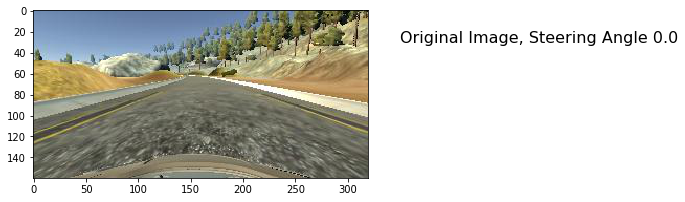

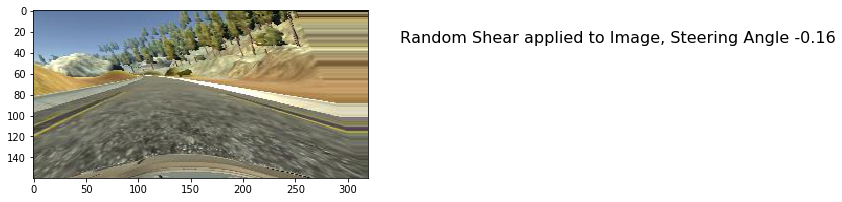

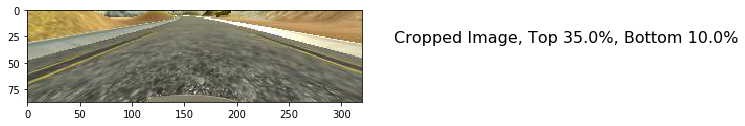

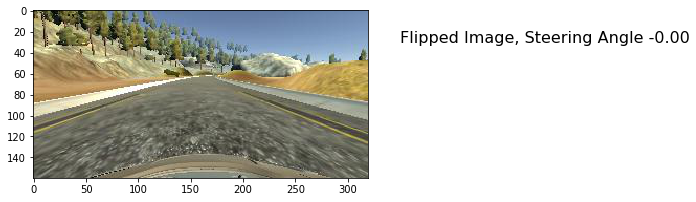

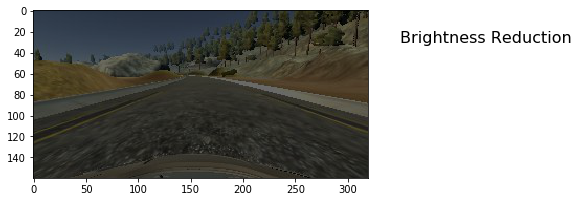

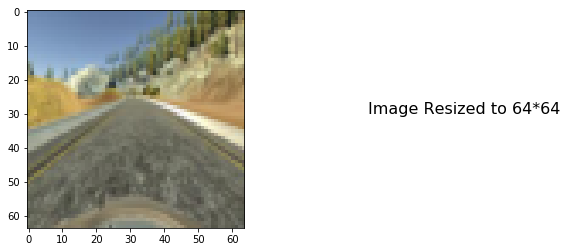

In [23]:
trial_row = train_log.iloc[2400]
steering_angle1 = trial_row['steering']
image1 = load_img((DATA_DIR + trial_row['center']).strip())
image1 = np.array(image1)

show_image_processing(image1, steering_angle1)

In [24]:
def roundup(x, base=100):
    return int(base * round(float(x)/base))

In [25]:
number_of_epochs = 8
number_of_train_samples = roundup (len(train_log), base=GENERATOR_BATCH_SIZE)
number_of_validation_samples = roundup (len(valid_log), base=GENERATOR_BATCH_SIZE)
learning_rate = 1e-4
activation_relu = 'relu'

In [26]:
model = get_model()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 64, 64, 3)     0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 32, 32, 24)    1824        lambda_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 32, 32, 24)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 16, 16, 36)    21636       activation_1[0][0]               
___________________________________________________________________________________________

In [27]:
model.fit_generator(train_gen,
                    samples_per_epoch=number_of_train_samples,
                    nb_epoch=number_of_epochs,
                    validation_data=valid_gen,
                    nb_val_samples=number_of_validation_samples,
                    verbose=1)
save_model(model) 

Epoch 1/8
6432/6432 [==============================] - 32s - loss: 0.0816 - val_loss: 0.0295

In [30]:
test_loss = model.evaluate_generator(test_gen, len(test_log))
print(test_loss)

0.0127132979508
